
# Sesión 1 — NLP clásico (BoW / TF‑IDF / n‑gramas)

Este notebook reproduce el flujo de `scripts/main.py` pero mostrando **gráficas inline** y guardando las figuras en `outputs/`.


In [51]:

# %% Imports y utilidades
from __future__ import annotations

import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# %% Setup de paths para poder importar desde src/
import sys
from pathlib import Path

# Ruta a la raíz del proyecto (la carpeta que contiene 'src/')
PROJECT_ROOT = Path("/home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase1MarcoParra")

# Si quieres que sea automático (funciona desde notebooks/ o raíz):
# candidates = [Path.cwd(), Path.cwd().parent]
# PROJECT_ROOT = next((p for p in candidates if (p / "src").exists()), PROJECT_ROOT)

SRC_DIR = PROJECT_ROOT / "src"
if not SRC_DIR.exists():
    raise FileNotFoundError(f"No se encontró {SRC_DIR}. Revisa la ruta a tu proyecto.")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR existe:", SRC_DIR.exists())


from src.data.loader import load_corpus
from src.features.vectorize import vectorize_all, top_terms_for_doc

def ensure_dir(path: str | os.PathLike) -> None:
    Path(path).mkdir(parents=True, exist_ok=True)

# Ajustes de gráficos
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


PROJECT_ROOT: /home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase1MarcoParra
SRC_DIR existe: True


## Parámetros

In [52]:

# %% Parámetros (puedes editar y volver a ejecutar)
corpus_path = PROJECT_ROOT /"data/clinical_notes.txt"  # una nota por línea
out_dir = "outputs"                      # carpeta de salida de figuras

# Vectorización
ngram_min = 1
ngram_max = 3
min_df = 2          # ignora términos muy raros (aparecen en <2 docs)
max_df = 0.85       # ignora términos muy comunes (aparecen en >85% docs)

# Reportes
topk = 10           # términos por documento
docs_top = 3        # cuántos documentos graficar (0..N-1)


## 1) Cargar corpus

In [53]:


# %% Carga corpus
ensure_dir(out_dir)
docs: List[str] = load_corpus(corpus_path)
print(f"Corpus cargado: {len(docs)} documentos")


Corpus cargado: 10 documentos


## 2) Vectorización (BoW y TF‑IDF)

In [54]:

# %% Vectorización
X_bow, X_tfidf, feat_names, _, _ = vectorize_all(
    docs=docs,
    ngram_range=(ngram_min, ngram_max),
    min_df=min_df,
    max_df=max_df,
    sublinear_tf=True,
    norm="l2",
)
print(f"BoW shape: {X_bow.shape} | TF-IDF shape: {X_tfidf.shape}")


BoW shape: (10, 16) | TF-IDF shape: (10, 16)


## 3) Similaridad por coseno (TF‑IDF) + Heatmap

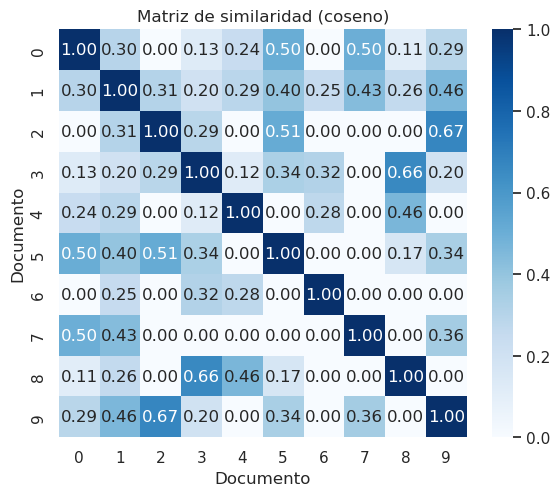

Heatmap guardado en: outputs/similarity_heatmap.png


In [55]:

# %% Similaridad y heatmap inline + guardado
sim: np.ndarray = cosine_similarity(X_tfidf)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(sim, annot=True, fmt=".2f", cmap="Blues", square=True, ax=ax)
ax.set_title("Matriz de similaridad (coseno)")
ax.set_xlabel("Documento")
ax.set_ylabel("Documento")
heatmap_path = os.path.join(out_dir, "similarity_heatmap.png")
plt.tight_layout()
plt.savefig(heatmap_path, dpi=150)
plt.show()

print("Heatmap guardado en:", heatmap_path)


## 4) Top términos por documento (TF‑IDF)

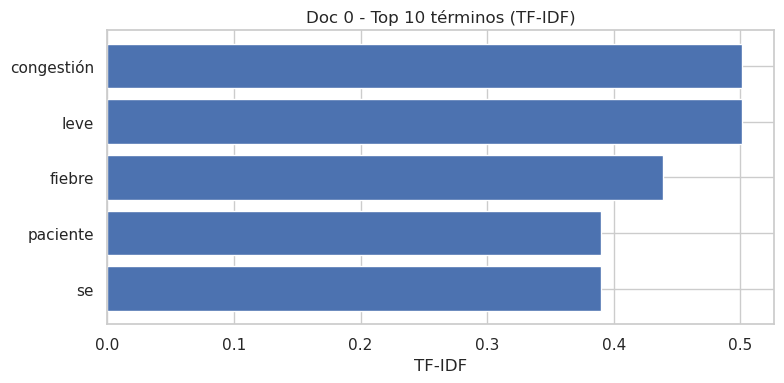

Top términos Doc 0: outputs/doc0_top_terms.png


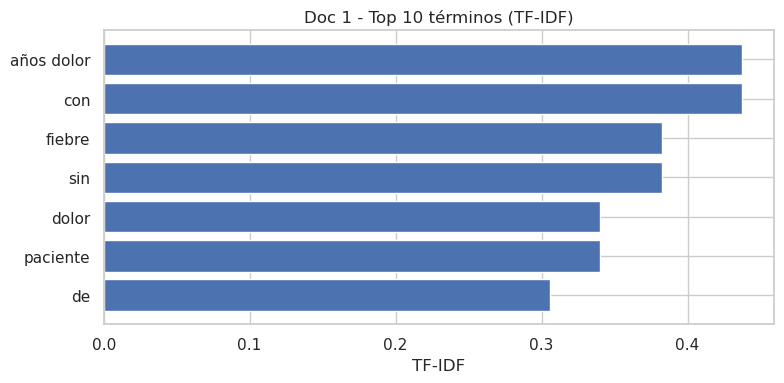

Top términos Doc 1: outputs/doc1_top_terms.png


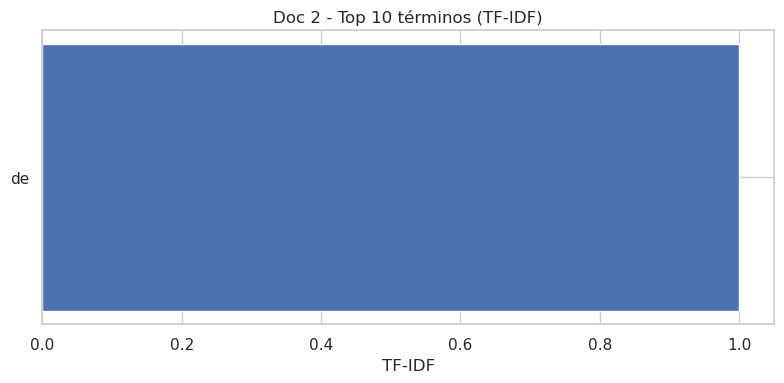

Top términos Doc 2: outputs/doc2_top_terms.png


In [56]:

# %% Gráficas de términos top (inline + guardado)
n_docs = min(docs_top, X_tfidf.shape[0])

for d in range(n_docs):
    top = top_terms_for_doc(X_tfidf, feat_names, doc_idx=d, k=topk)
    if not top:
        print(f"Doc {d}: sin términos válidos tras el filtrado (min_df/max_df).")
        continue

    terms, scores = zip(*top)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(terms, scores)
    ax.invert_yaxis()
    ax.set_title(f"Doc {d} - Top {topk} términos (TF-IDF)")
    ax.set_xlabel("TF-IDF")
    plt.tight_layout()

    out_png = os.path.join(out_dir, f"doc{d}_top_terms.png")
    plt.savefig(out_png, dpi=150)
    plt.show()

    print(f"Top términos Doc {d}: {out_png}")


## 5) Pares más similares

In [57]:

# %% Pares más similares (excluye diagonal)
print("Documentos más similares (TF-IDF + coseno):")
for i in range(sim.shape[0]):
    row = sim[i].copy()
    row[i] = -np.inf
    j = int(np.argmax(row))
    print(f"  D{i} ↔ D{j} | similitud={sim[i, j]:.3f}")


Documentos más similares (TF-IDF + coseno):
  D0 ↔ D5 | similitud=0.504
  D1 ↔ D9 | similitud=0.457
  D2 ↔ D9 | similitud=0.668
  D3 ↔ D8 | similitud=0.657
  D4 ↔ D8 | similitud=0.464
  D5 ↔ D2 | similitud=0.512
  D6 ↔ D3 | similitud=0.315
  D7 ↔ D0 | similitud=0.499
  D8 ↔ D3 | similitud=0.657
  D9 ↔ D2 | similitud=0.668
